# Running DARP on Actual Maps

**Known Issues**
- Reprojection function for projecting the coverage path onto the map isn't proper, this is apparent for larger areas.
- Somehing goes wrong sometimes withrespect to area division, it may be related to when the area of coverage of the drone is large.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from zipfile import ZipFile

import shapely
import shapely.geometry
import geopandas as gpd
import contextily as cx
from geopy import distance
from skimage import measure
from skimage.draw import polygon

from cpp_algorithms import conversion
from cpp_algorithms import adjacency_test
from cpp_algorithms.conversion.conversion import conversion
from cpp_algorithms import plot, imshow, cpp, imshow_scatter
from cpp_algorithms.conversion.conversion_helpers import  get_gpdframe

# Helper Functions

In [46]:
EPSG=4326
FEATURES = ["coverage", "obstacle", "fuel", "drone"]
colors = ["#e91e63","#3f51b5","#00838f","#ff8f00","#4caf50"]

def get_features_dict(shape_files, key='type', fnames=FEATURES):
    """
    Name of the features should be shapefile 
    `key` column values
    """
    features = {}
    for name in fnames:
        features[name] = []
        
    for sh in shape_files:
        for rows in sh.iterrows():
            for k in features:
                if rows[1][key].find(k) >= 0:
                    features[k].append(rows[1].geometry)
    return features

def get_final_coverage_polygon(features):
    """
    Union of coverage and difference of
    obstacles.
    """
    final = features['coverage'][0]
    for cov in features['coverage']:
        final = final.union(cov)
    for obs in features['obstacle']:
        final = final.difference(obs)
    return final


def create_gdframe(features, crs=f"EPSG:{EPSG}", no_points=False):
    """
    Create GeoDataFrame from features
    """
    final_coverage = get_final_coverage_polygon(features)
    points = []
    if not no_points:
        for d in features['drone']:
            points.append({
                'type':'drone',
                'geometry':d
            })
        for f in features['fuel']:
            points.append({
                'type':'fuel',
                'geometry':d
            })
    points.append({
        'type':'coverage',
        'geometry':final_coverage})
    return gpd.GeoDataFrame(points, crs=crs)

def get_hv_wh(final_coverage):
    """
    Get haversine calcualted width and height of
    the smallest bounding rectangle of the coverage area.
    """
    llng, llat, rlng, rlat =  final_coverage.bounds
    ll = (llat,llng)
    lr = (llat,rlng)
    tr = (rlat,rlng)
    tl = (rlat,llng)
    w = distance.distance(ll,lr)
    h = distance.distance(ll,tl)
    return w, h


def read_shapefile(path, to_del=False):
    """
    Path of the zip file containing the .shp
    """
    path = Path(path)
    ZipFile(path).extractall(path.parent)
    shp_all = []
    for shfile in (path.parent/"layers").iterdir():
        if shfile.suffix == ".shp":
            shp_all.append(gpd.read_file(shfile))
    if to_del:
        (path.parent/"layers").unlink()
    return shp_all

"""
Convert to raster
"""
def get_scale(final_coverage_polygon, meter=1):
    """
    Returns the supposed longside of the area.
    """
    w,h = get_hv_wh(final_coverage_polygon)
    w = w.m
    h = h.m
    return int(np.round((np.array([w,h])/meter).max()))

def get_raster(gpdf_final, scale=2000,CRS = f"EPSG:4326"):
    """
    Returns rasterised version for the projection
    """
    assert len(gpdf_final) == 1
    try:
        shp = gpdf_final.to_crs(crs=CRS)
    except:
        shp = gpdf_final.set_crs(crs="EPSG:4326")
    
    ext = np.array(shp.geometry[0].exterior).copy()
    ite = map(np.array,shp.geometry[0].interiors)
    
    mn = ext.min(axis=0)
    mix = ext - mn
    mx = mix.max()
    mix *= scale/mx
    mix = np.int64(mix)
    sh = mix.max(axis=0)
    
    r,c = polygon(*mix.T,sh)
    p = np.full(mix.max(axis=0),-1)
    p[r,c] = 0 
    
    for o in ite:
        r,c = polygon(*np.int16((o-mn)*scale/mx).T,sh)
        p[r,c] = -1
        
    return p, mn, mx, sh

def down_sample(side, area_map, points, meter=1):
    """
    Down samples the projection so each pixel 
    represents a drone's coverage area.
    """
    st = int(side/meter)
    area_map = area_map.copy()
    area_map[area_map == -1] = 1
    vals = []
    for i,point in enumerate(points):
        point=np.array(point)
        x,y = point.T
        area_map[x,y] = i+2
        vals.append(i+2)
    
    temp = measure.block_reduce(area_map, (st,st), np.max,cval=0)
    temp[temp==1] = -1
    points = []
    for val in vals:
        points_ = np.stack(np.where(temp==val)).T
        points.append(list(map(tuple,points_)))
        temp[temp == val] = 0
    return temp, points
    
def coords_to_points(cps):
    """
    Converts the (x,y) to lat and long values in a GeoDataFrame
    """
    ls = []
    for cp in cps:
        geometry = shapely.geometry.LineString(cp.reshape(-1,2))
        ls.append(gpd.GeoDataFrame([{"type":"drone", "geometry":geometry}],crs=f"EPSG:4326"))
    return ls

def coo_to_points(gpdf_points, mn, mx, key="type", scale=2000):
    """
    Does the opposite of the above function.
    """
    types = []
    points = []
    for p in gpdf_points.iterrows():
        if p[1][key] not in types:
            types.append(p[1][key])
            points.append([])
            
        i = types.index(p[1][key]) 
        coords = np.array(p[1].geometry.coords)
        points[i].append(tuple(np.int64((coords - mn)*scale/mx)[0]))
    return points, types

def plot_and_display(path,side=100,meter=4,online=True, figsize=(15,15)):
    """
    Calls all the above functions for the given parameters.
    """
    shf = read_shapefile(path)
    features = get_features_dict(shf)
    gpdf_final = create_gdframe(features, no_points=True)
    final_coverage_polygon = gpdf_final.geometry[0]
    gpdf_points = shf[1]
    gpdf_points = gpdf_points.set_crs(epsg=EPSG)
    scale = get_scale(final_coverage_polygon, meter=meter)
    area_map_,mn,mx,sh = get_raster(gpdf_final, scale)
    points_, types = coo_to_points(gpdf_points, mn, mx, scale=scale)
    st = side/meter
    area_map, points = down_sample(side, area_map_, points_, meter=meter)

    coverage_path_ = cpp(area_map, [*points[0],*points[1]], pbar=True, online=online)
    coverage_path = list(map(lambda cp:((np.array(cp)*side)*mx/(scale*meter))+mn[None,None,:], coverage_path_[0]))
    imshow(area_map,figsize=figsize, cmap="Blues_r")
    [plot(cp,color=colors[i]) for i,cp in enumerate(coverage_path_[0])];

    paths = coords_to_points(coverage_path)
    epsg = 3857; conv_crs = f"EPSG:{epsg}"
    bounds = list(gpdf_final.to_crs(epsg=3857).bounds.iloc[0])
    ax = gpdf_final.to_crs(epsg=epsg).plot(figsize=figsize, alpha=0.6, edgecolor='black', color="lightgrey")
    [pth.to_crs(epsg=epsg).plot(ax=ax, edgecolor=colors[i],alpha=1) for i,pth in enumerate(paths)];
    cx.add_basemap(ax=ax, crs=conv_crs)
    ax.set_axis_off()

# Running Boustrophedon

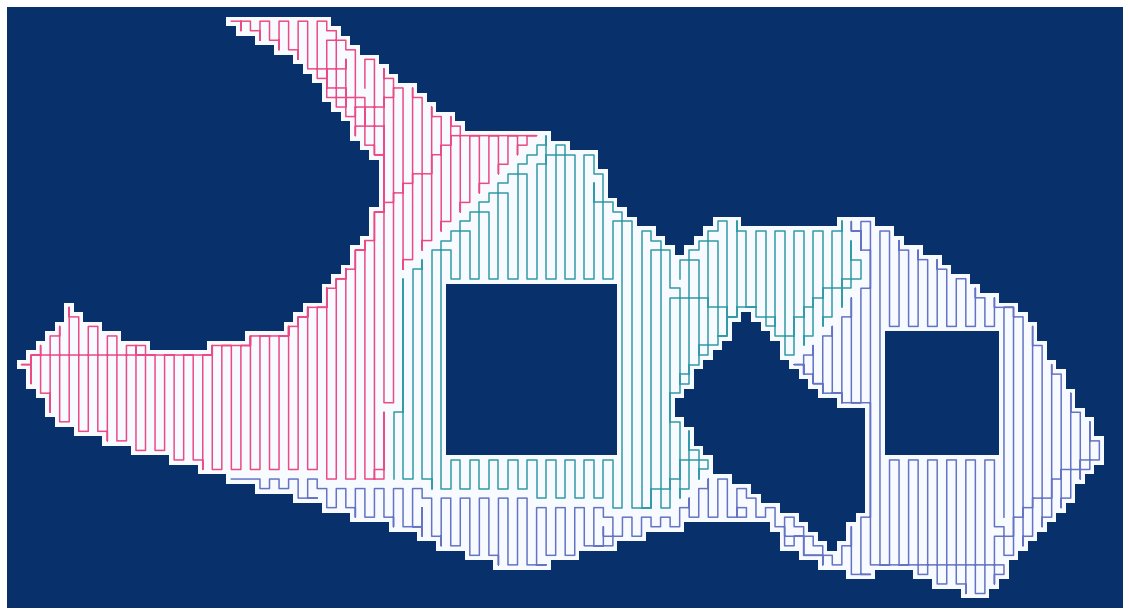

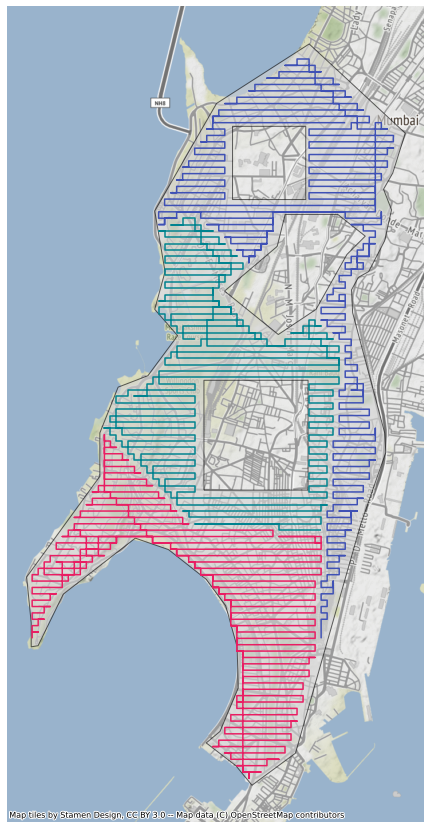

In [36]:
plot_and_display("./test_shps/kamathipura.zip")

# Running Wavefront

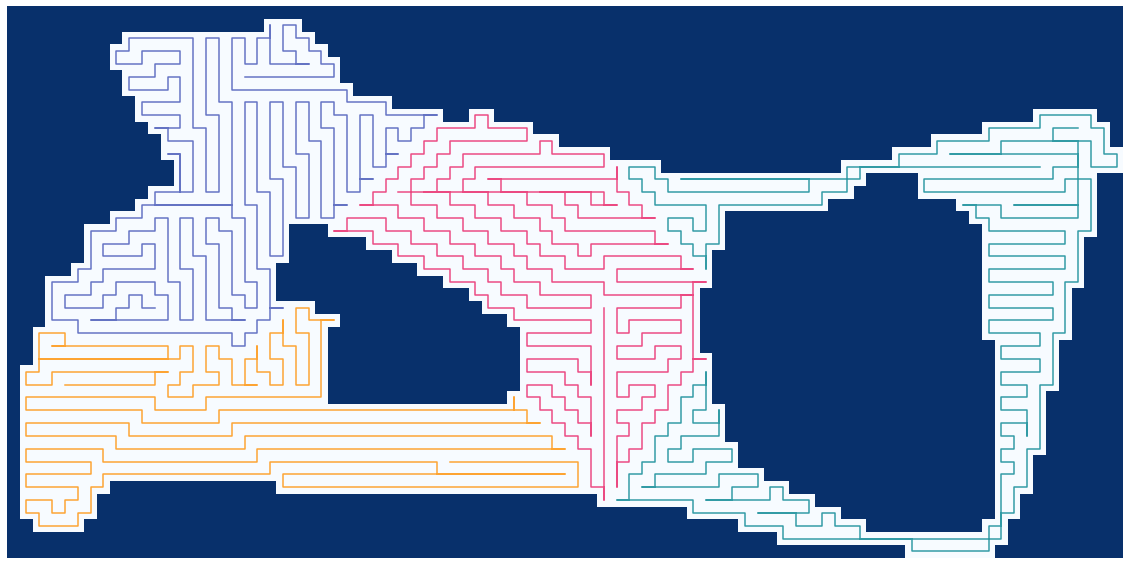

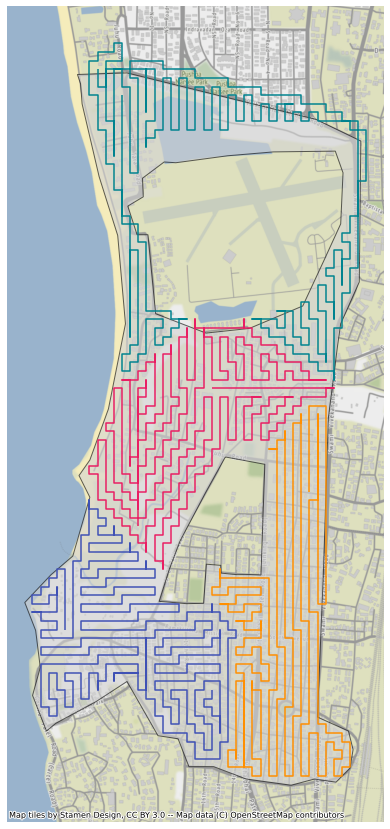

In [37]:
plot_and_display("./test_shps/juhu.zip", online="wavefront", side=50)

# Running STC

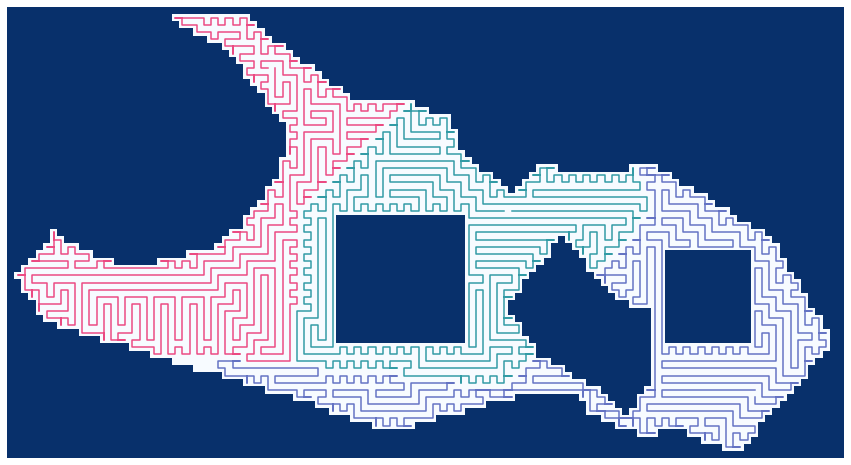

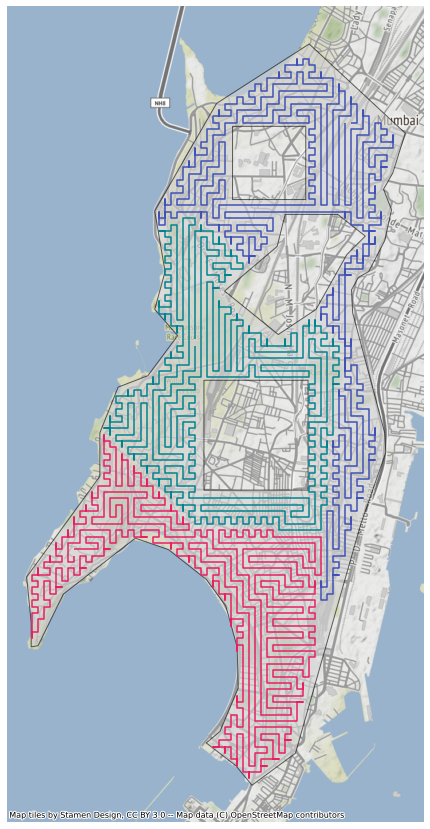

In [54]:
plot_and_display("./test_shps/kamathipura.zip",online=False)

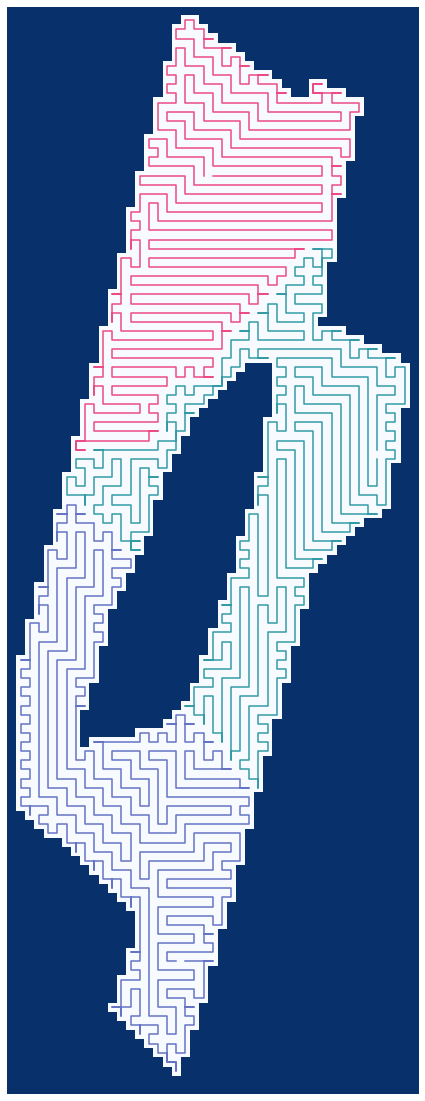

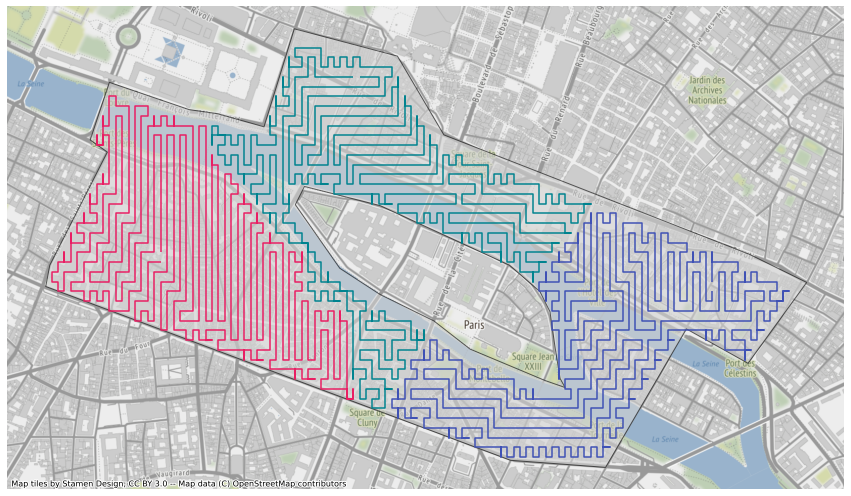

In [41]:
plot_and_display("./test_shps/paris.zip", online=False, side=20)

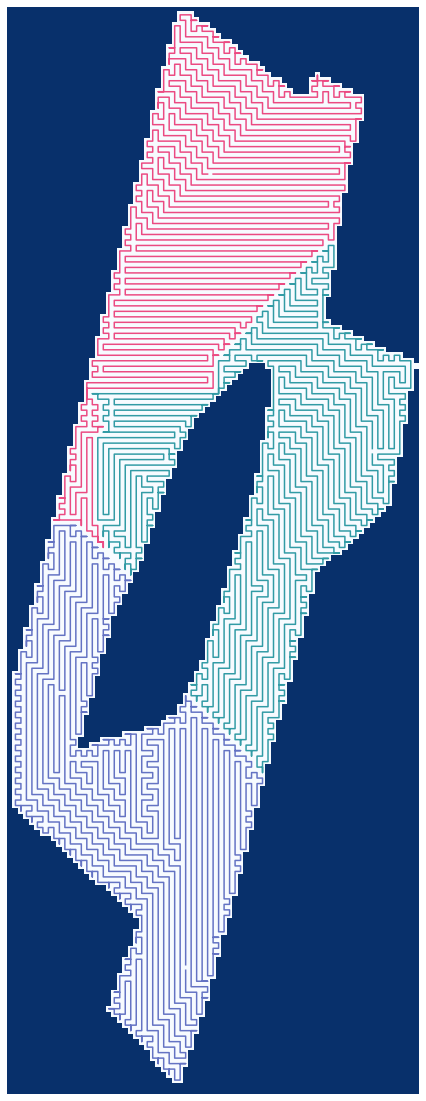

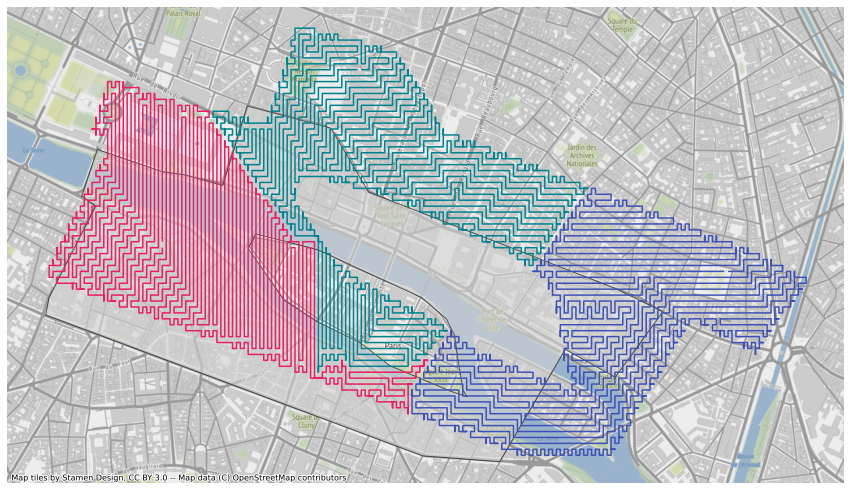

In [43]:
plot_and_display("./test_shps/paris.zip", online=False, side=15)

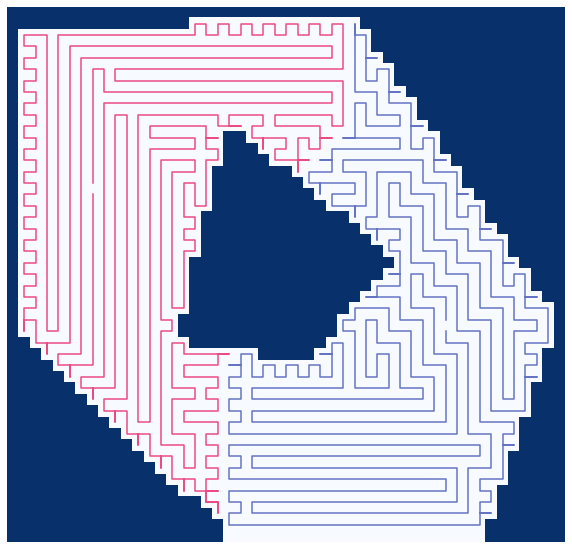

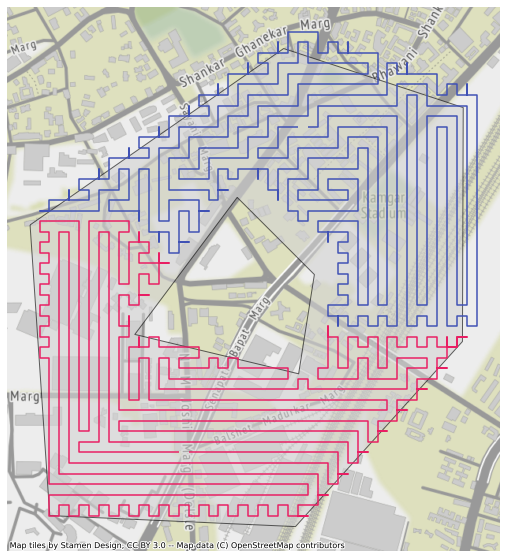

In [47]:
plot_and_display("./test_shps/mumb.zip", online=False, side=30, figsize=(10,10))